In [31]:
NOTEBOOK_NAME = "e025_late_use_catboost_increase_max_depth"

In [32]:
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib

from catboost import Pool
from catboost import CatBoostClassifier

In [33]:
train = pl.read_csv("../data/train.csv")
test = pl.read_csv("../data/test.csv")
era = pl.read_csv("../data/era_improve.csv")
sample_submission = pl.read_csv("../data/sample_submission.csv")

# 前処理

In [34]:
train = train.join(era, on="時代", how="left")
test = test.join(era, on="時代", how="left")

# データ型の変更

In [35]:
categorical_cols = [
    "棟名",
    "種別2",
    "国",
    "都道府県 ※美工品は「所有者住所（所在都道府県）」",
    "時代",
    "保管施設の名称",
    "所有者名",
    "管理団体又は責任者",
    "所在地",
]

In [36]:
# カウントエンコーディングを行う
merge_df = pl.concat([train[categorical_cols], test[categorical_cols]])

merge_count_df = merge_df.select(
    [pl.count().over(col).alias(f"{col}_count") for col in categorical_cols]
)

train_count_df = merge_count_df.slice(0, train.shape[0])
test_count_df = merge_count_df.slice(train.shape[0])

train = pl.concat([train, train_count_df], how="horizontal")
test = pl.concat([test, test_count_df], how="horizontal")

In [37]:
# Trainにしかないデータを削除する
def only_train_is_null(train: pl.DataFrame, test: pl.DataFrame, col: str):
    only_train = set(train.get_column(col).unique())
    only_test = set(test.get_column(col).unique())

    share_value = only_train & only_test

    return train.with_columns(
        pl.when(pl.col(col).is_in(list(share_value)))
        .then(pl.col(col))
        .otherwise(None)
        .alias(col)
    )


for col in categorical_cols:
    train = only_train_is_null(train, test, col)

In [38]:
from sklearn.preprocessing import LabelEncoder


def label_encoder(train: pd.Series, test: pd.Series) -> tuple[pd.Series, pd.Series]:
    le = LabelEncoder()
    labeld_sr = le.fit_transform(pd.concat([train, test]))
    return labeld_sr[: len(train)], labeld_sr[len(train) :]


train = train.to_pandas()
test = test.to_pandas()

for col in categorical_cols:
    train[col], test[col] = label_encoder(train[col], test[col])

train = pl.from_pandas(train)
test = pl.from_pandas(test)

In [39]:
# for col in categorical_cols:
#     train = train.with_columns(pl.col(col).cast(pl.Categorical).alias(col))
#     test = test.with_columns(pl.col(col).cast(pl.Categorical).alias(col))

# Fold

In [40]:
FOLD_NUM = 5

In [41]:
empty = np.zeros(train.height)
fold = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=33)

for idx, (_, val_idx) in enumerate(fold.split(train, train.get_column("is_kokuhou"))):
    empty[val_idx] = idx

train = train.with_columns(pl.Series(empty).cast(pl.Int64).alias("fold"))

# CatBoost

In [42]:
use_col = []

base_col = ["緯度", "経度", "開始", "終了"]

use_col += base_col
use_col += categorical_cols
use_col += [f"{col}_count" for col in categorical_cols]

len(use_col)

22

In [43]:
use_col

['緯度',
 '経度',
 '開始',
 '終了',
 '棟名',
 '種別2',
 '国',
 '都道府県 ※美工品は「所有者住所（所在都道府県）」',
 '時代',
 '保管施設の名称',
 '所有者名',
 '管理団体又は責任者',
 '所在地',
 '棟名_count',
 '種別2_count',
 '国_count',
 '都道府県 ※美工品は「所有者住所（所在都道府県）」_count',
 '時代_count',
 '保管施設の名称_count',
 '所有者名_count',
 '管理団体又は責任者_count',
 '所在地_count']

In [44]:
def get_lgbm_prediction(
    train: pl.DataFrame, use_col: list, params: dict, FOLD_NUM: int = 5
) -> tuple[np.ndarray, list]:
    print(params)
    # 学習データ全体に対する推論結果を保存するobjectを作成
    oof = np.zeros((len(train)))

    # テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
    models = []

    # Cross Validationによる学習の実施
    for fold in range(FOLD_NUM):
        print(f"Start fold {fold}")

        # polarsをpandasに変換
        train_pd = train.to_pandas()

        # foldごとにtrainとvalidに分ける
        train_fold = train_pd[train_pd["fold"] != fold]
        valid_fold = train_pd[train_pd["fold"] == fold]

        # X(説明変数)とy(目的変数)に分ける
        X_train = train_fold.drop("is_kokuhou", axis=1)
        X_valid = valid_fold.drop("is_kokuhou", axis=1)
        y_train = train_fold[["is_kokuhou"]]
        y_valid = valid_fold[["is_kokuhou"]]

        # 利用する説明変数に限定する
        X_train = X_train[use_col]
        X_valid = X_valid[use_col]

        # CatBoostが認識可能な形にデータセットを変換
        cat_train = Pool(X_train, y_train, cat_features=categorical_cols)
        cat_valid = Pool(X_valid, y_valid, cat_features=categorical_cols)

        # モデルの学習
        model = CatBoostClassifier(**params)
        model.fit(
            cat_train,
            eval_set=cat_valid,
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=False,
        )

        # モデルを保存
        models.append(model)

        # validデータに対する推論
        y_valid_pred = model.predict_proba(X_valid)[:, 1]

        # validデータに対する推論の性能を計算
        calc_f1_score = roc_auc_score(y_valid, y_valid_pred)
        print(f"fold {fold} Score: {calc_f1_score}")

        # oofに推論結果を保存
        valid_idx = X_valid.index
        oof[valid_idx] = y_valid_pred
    return oof, models

In [45]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
# params = {"objective": "binary", "metric": "auc", "verbosity": -1, "seed": 42}

In [46]:
from sklearn.metrics import f1_score

seed_ave_models = []
oofs = []
oof_scores = []
for seed in [42]:
    params = {
        "objective": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        "learning_rate": 0.01,
        "iterations": 10000,
        "random_seed": seed,
        "od_type": "Iter",
        "use_best_model": True,
        "max_depth": 16,
    }
    # params = {"objective": "binary", "metric": "auc", "verbosity": -1, "seed": seed}
    # ↑の状態でseedだけ変えても、結果が変わらなかった
    oof, models = get_lgbm_prediction(train, use_col, params)
    oof_score = roc_auc_score(y_true=train.get_column("is_kokuhou"), y_score=oof)

    seed_ave_models.extend(models)
    oofs.append(oof)
    oof_scores.append(oof_score)

# 0.01 から 0.99 まで 0.01 刻みで閾値を変えて、F1 score を計算する
max_f1_score = 0

oof_score_mean = np.mean(oof_scores)
oof_mean = np.vstack(oofs).mean(axis=0)

for thr in np.arange(0.01, 1, 0.01):
    calc_f1_score = f1_score(
        train.get_column("is_kokuhou"), (oof_mean > thr).astype(int)
    )
    print(f"thr: {thr}, f1_score: {calc_f1_score}")
    if max_f1_score < calc_f1_score:
        max_f1_score = calc_f1_score
        best_thr = thr
print("AUC: ", oof_score_mean)
print(f"Optimized thr: {best_thr}, f1 score: {max_f1_score}")

{'objective': 'Logloss', 'eval_metric': 'AUC', 'task_type': 'CPU', 'learning_rate': 0.01, 'iterations': 10000, 'random_seed': 42, 'od_type': 'Iter', 'use_best_model': True, 'max_depth': 8}
Start fold 0
fold 0 Score: 0.839122383252818
Start fold 1
fold 1 Score: 0.7937439613526571
Start fold 2
fold 2 Score: 0.8429347826086956
Start fold 3
fold 3 Score: 0.8251972624798712
Start fold 4
fold 4 Score: 0.8138039428439218
thr: 0.01, f1_score: 0.1562204724409449
thr: 0.02, f1_score: 0.1861271676300578
thr: 0.03, f1_score: 0.2157676348547718
thr: 0.04, f1_score: 0.24245689655172414
thr: 0.05, f1_score: 0.26441717791411046
thr: 0.060000000000000005, f1_score: 0.28157349896480327
thr: 0.06999999999999999, f1_score: 0.29596073990184973
thr: 0.08, f1_score: 0.3076923076923077
thr: 0.09, f1_score: 0.3134461264470169
thr: 0.09999999999999999, f1_score: 0.3254901960784314
thr: 0.11, f1_score: 0.3335086796422935
thr: 0.12, f1_score: 0.34059633027522934
thr: 0.13, f1_score: 0.3435736677115988
thr: 0.14, 

In [47]:
oof_score_mean = np.mean(oof_scores)
oof_mean = np.vstack(oofs).mean(axis=0)

<Axes: xlabel='Importances', ylabel='Feature Id'>

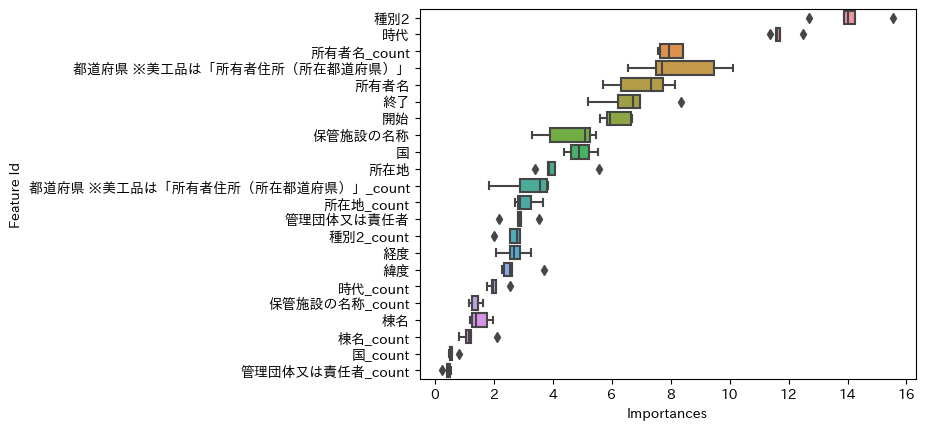

In [48]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.get_feature_importance(prettified=True) for model in models
]

# 特徴量重要度の中央値をとり、sortする
feature_importance_sorted_median = (
    pd.concat(feature_importances)
    .groupby("Feature Id")
    .median()
    .sort_values(by="Importances", ascending=False)
)

# 表示する順番を指定、特徴量重要度の中央値が大きい順に並ぶよう計算
order = feature_importance_sorted_median.index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(
    data=pd.concat(feature_importances),
    x="Importances",
    y="Feature Id",
    orient="h",
    order=order,
)

In [49]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array(
    [
        model.predict_proba(test.select(use_col).to_pandas())[:, 1]
        for model in seed_ave_models
    ]
)

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

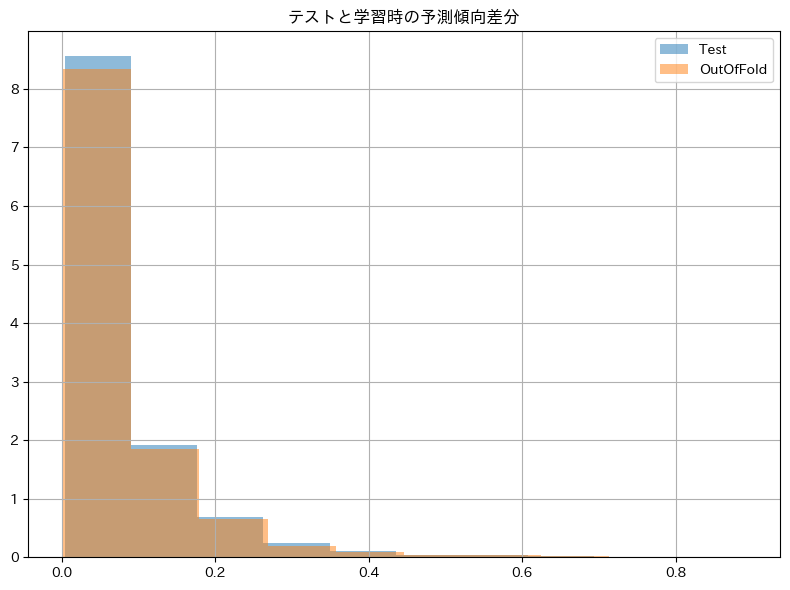

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [51]:
train.with_columns(pl.Series(oof).cast(pl.Float64).alias("oof")).write_csv(
    f"../oof/oof_{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"
)

In [52]:
sample_submission.with_columns(pl.Series("is_kokuhou", pred > best_thr).cast(int))

is_kokuhou
i64
0
0
1
0
0
0
0
0
0


In [53]:
sample_submission = sample_submission.with_columns(
    pl.Series("is_kokuhou", pred > best_thr).cast(int)
)
sample_submission

is_kokuhou
i64
0
0
1
0
0
0
0
0
0


In [54]:
sample_submission.write_csv(
    f"../sub/{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"
)
f"../sub/{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"

'../sub/e024_use_catboost_f1score_0.3511_auc_0.8210.csv'